In [1]:
# ================================================
# 1. REPRODUCIBILITY SETTINGS 
# ================================================
from pathlib import Path

import random
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
import copy

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# ----- Reproducibility -----
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ================================================
# 2. DEFAULT PATHS FOR DATASET
# ================================================
ROOT = Path("Amazon_products")   # dataset root directory

# Main corpus
TRAIN_CORPUS_PATH = ROOT / "train" /  "train_corpus.txt"       # pid \t text
TEST_CORPUS_PATH  = ROOT / "test" / "test_corpus.txt"        # pid \t text

# Taxonomy & class meta
CLASSES_PATH      = ROOT / "classes.txt"            # class_id \t class_name
HIERARCHY_PATH    = ROOT / "class_hierarchy.txt"    # parent_id \t child_id
KEYWORDS_PATH     = ROOT / "class_related_keywords.txt"

# Constants
NUM_CLASSES = 531
MIN_LABELS = 2     # minimum number of labels per sample
MAX_LABELS = 3     # maximum number of labels per sample

# Check paths
print("\n== Data path check ==")
for p in [TRAIN_CORPUS_PATH, TEST_CORPUS_PATH,
          CLASSES_PATH, HIERARCHY_PATH, KEYWORDS_PATH]:
    print(f"{p} -> {p.exists()}")

Device: cuda

== Data path check ==
Amazon_products/train/train_corpus.txt -> True
Amazon_products/test/test_corpus.txt -> True
Amazon_products/classes.txt -> True
Amazon_products/class_hierarchy.txt -> True
Amazon_products/class_related_keywords.txt -> True


In [2]:
# ================================================
# 2. DATA LOADING
# ================================================

def load_corpus(path):
    """
    Load corpus file (pid \\t text) as {pid: text} dictionary.
    """
    pid2text = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                pid, text = parts
                pid2text[pid] = text
    return pid2text

# Load corpus
print("Loading train/test corpus...")

pid2text_train = load_corpus(TRAIN_CORPUS_PATH)
pid2text_test  = load_corpus(TEST_CORPUS_PATH)

pid_list_train = list(pid2text_train.keys())
pid_list_test  = list(pid2text_test.keys())

print("Train samples:", len(pid2text_train))
print("Test samples :", len(pid2text_test))

# Quick sample check
for i, (pid, text) in enumerate(pid2text_train.items()):
    print(f"Example train sample #{i}: pid={pid}, text={text[:80]}...")
    break

Loading train/test corpus...
Train samples: 29487
Test samples : 19658
Example train sample #0: pid=0, text=omron hem 790it automatic blood pressure monitor with advanced omron health mana...


In [3]:
# ================================================
# 3. CLASS METADATA LOADING
# ================================================

def load_classes(path):
    """
    classes.txt : class_id \\t class_name
    returns: id2label, label2id
    """
    id2label = {}
    label2id = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 2:
                continue
            cid, name = parts
            cid = int(cid)
            id2label[cid] = name
            label2id[name] = cid
    return id2label, label2id


def load_hierarchy(path):
    """
    class_hierarchy.txt : parent_id \\t child_id
    returns: edges (list of tuples)
    """
    edges = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 2:
                continue
            p, c = map(int, parts)
            edges.append((p, c))
    return edges


def load_keywords(path, label2id):
    """
    class_related_keywords.txt : CLASS_NAME: kw1, kw2,...
    returns: {class_id: [kws]}
    """
    d = {cid: [] for cid in label2id.values()}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ":" not in line:
                continue
            name, kws = line.strip().split(":", 1)
            kws = [k.strip() for k in kws.split(",") if k.strip()]
            if name in label2id:
                cid = label2id[name]
                d[cid] = kws
    return d


# ----------------- Load all class meta -----------------
print("Loading class metadata...")

id2label, label2id = load_classes(CLASSES_PATH)
edges = load_hierarchy(HIERARCHY_PATH)
label_keywords = load_keywords(KEYWORDS_PATH, label2id)

print("Num classes:", len(id2label))
print("Num edges in taxonomy:", len(edges))
print()

# Small check
example_id = 0
print("Example class id:", example_id)
print("Name:", id2label[example_id])
print("Keywords:", label_keywords[example_id])

Loading class metadata...
Num classes: 531
Num edges in taxonomy: 568

Example class id: 0
Name: grocery_gourmet_food
Keywords: ['snacks', 'condiments', 'beverages', 'specialty_foods', 'spices', 'cooking_oils', 'baking_ingredients', 'gourmet_chocolates', 'artisanal_cheeses', 'organic_foods']


In [ ]:
# ================================================
# 4. TEXT EMBEDDING WITH MPNet v2 (all-mpnet-base-v2)
# ================================================
from sentence_transformers import SentenceTransformer
import numpy as np
from pathlib import Path

# ----- Embedding model -----
EMB_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"

print(f"\n== Loading embedding model: {EMB_MODEL_NAME} ==")
mpnet_model = SentenceTransformer(
    EMB_MODEL_NAME,
    device=device
)

def encode_mpnet(texts, batch_size: int = 64, normalize: bool = True):
    """
    MPNet v2(all-mpnet-base-v2) 임베딩 생성 함수.
    normalize=True → cosine similarity 사용 용이.
    """
    emb = mpnet_model.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=True,
        normalize_embeddings=normalize,
    )
    return emb


# ----- Save directory -----
EMB_DIR = ROOT / "embeddings_mpnet"
EMB_DIR.mkdir(exist_ok=True, parents=True)
print("Embedding dir:", EMB_DIR)


# ================================================
# 4-1. DOCUMENT EMBEDDINGS (TRAIN / TEST)
# ================================================
print("\n== Building MPNet document embeddings (train/test) ==")

train_texts = [pid2text_train[pid] for pid in pid_list_train]
test_texts  = [pid2text_test[pid] for pid in pid_list_test]

print("Num train texts:", len(train_texts))
print("Num test texts :", len(test_texts))

# 임베딩 계산
train_doc_mpnet = encode_mpnet(train_texts)
test_doc_mpnet  = encode_mpnet(test_texts)

print("train_doc_mpnet shape:", train_doc_mpnet.shape)
print("test_doc_mpnet shape :", test_doc_mpnet.shape)

# 저장
np.save(EMB_DIR / "train_doc_mpnet.npy", train_doc_mpnet)
np.save(EMB_DIR / "test_doc_mpnet.npy",  test_doc_mpnet)

np.save(EMB_DIR / "pid_list_train.npy", np.array(pid_list_train))
np.save(EMB_DIR / "pid_list_test.npy",  np.array(pid_list_test))


# ================================================
# 4-2. CLASS EMBEDDINGS (NAME / NAME+KEYWORDS)
# ================================================
print("\n== Building MPNet class embeddings ==")

class_ids = sorted(id2label.keys())
class_names = [id2label[cid] for cid in class_ids]

# (1) class name 임베딩
class_name_mpnet = encode_mpnet(class_names)
np.save(EMB_DIR / "class_name_mpnet.npy", class_name_mpnet)

print("class_name_mpnet shape:", class_name_mpnet.shape)

# (2) class name + keyword 텍스트
merged_class_texts = []
for cid in class_ids:
    name = id2label[cid]
    kws = label_keywords.get(cid, [])
    if kws:
        merged = name + " : " + ", ".join(kws)
    else:
        merged = name
    merged_class_texts.append(merged)

class_kw_mpnet = encode_mpnet(merged_class_texts)
np.save(EMB_DIR / "class_kw_mpnet.npy", class_kw_mpnet)

print("class_kw_mpnet shape:", class_kw_mpnet.shape)

print("\n== MPNet embedding step completed successfully. ==")

/opt/conda/envs/esci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



== Loading embedding model: sentence-transformers/all-mpnet-base-v2 ==


/opt/conda/envs/esci/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding dir: Amazon_products/embeddings_mpnet

== Building MPNet document embeddings (train/test) ==
Num train texts: 29487
Num test texts : 19658


Batches:   0%|          | 0/461 [00:00<?, ?it/s]

In [4]:
# ================================================
# LOAD MPNet v2 EMBEDDINGS
# ================================================
import numpy as np
from pathlib import Path

# MPNet 임베딩 저장 경로 (앞에서 만든 폴더)
EMB_MP_DIR = ROOT / "embeddings_mpnet"

print("MPNet embedding dir:", EMB_MP_DIR)

# ----- 1. Train/Test 문서 임베딩 로딩 -----
train_doc_emb = np.load(EMB_MP_DIR / "train_doc_mpnet.npy")   # (N_train, dim)
test_doc_emb  = np.load(EMB_MP_DIR / "test_doc_mpnet.npy")    # (N_test, dim)

# ----- 2. 클래스 임베딩 로딩 -----
class_name_emb = np.load(EMB_MP_DIR / "class_name_mpnet.npy")  # (C, dim)
class_kw_emb   = np.load(EMB_MP_DIR / "class_kw_mpnet.npy")    # (C, dim)

# ----- 3. pid 리스트 -----
pid_list_train = np.load(EMB_MP_DIR / "pid_list_train.npy", allow_pickle=True)
pid_list_test  = np.load(EMB_MP_DIR / "pid_list_test.npy",  allow_pickle=True)

# ----- 4. shape 확인 -----
print("train_doc_emb:", train_doc_emb.shape)
print("test_doc_emb :", test_doc_emb.shape)
print("class_name_emb:", class_name_emb.shape)
print("class_kw_emb  :", class_kw_emb.shape)
print("train IDs:", len(pid_list_train))
print("test IDs :", len(pid_list_test))

MPNet embedding dir: Amazon_products/embeddings_mpnet
train_doc_emb: (29487, 768)
test_doc_emb : (19658, 768)
class_name_emb: (531, 768)
class_kw_emb  : (531, 768)
train IDs: 29487
test IDs : 19658


In [5]:
# ================================================
# 6. TAXONOMY UTILS (FROM edges)
# ================================================
from collections import defaultdict

class Taxonomy:
    def __init__(self, num_classes, edges):
        self.num_classes = num_classes
        self.children = defaultdict(list)
        self.parent = {cid: None for cid in range(num_classes)}

        for p, c in edges:
            self.children[p].append(c)
            self.parent[c] = p

        self.roots = [cid for cid, p in self.parent.items() if p is None]

    def get_ancestors(self, cid):
        """cid의 조상 리스트 (자기 자신 제외, root에서부터 오름차순)."""
        res = []
        cur = self.parent[cid]
        while cur is not None:
            res.append(cur)
            cur = self.parent[cur]
        return res[::-1]

    def get_path(self, cid):
        """root → ... → cid까지 path (자기 자신 포함)."""
        return self.get_ancestors(cid) + [cid]

    def get_descendants(self, cid):
        """cid 포함 모든 자손 (자기 자신 제외할지 포함할지 선택 가능)."""
        res = []
        stack = [cid]
        while stack:
            cur = stack.pop()
            for ch in self.children[cur]:
                res.append(ch)
                stack.append(ch)
        return res
        

# Taxonomy 인스턴스 생성
taxonomy = Taxonomy(NUM_CLASSES, edges)
print("Roots:", taxonomy.roots)

Roots: [0, 3, 10, 23, 40, 169]


In [6]:
# ================================================
# 7. CORE CLASS MAPPING (Taxo-style, path score 기반)
# ================================================
import numpy as np

EMB_DIR = ROOT / "embeddings"

# 7-1. 임베딩 로드
train_doc_emb = np.load(EMB_DIR / "train_doc_gte.npy")       # (N_train, dim)
test_doc_emb  = np.load(EMB_DIR / "test_doc_gte.npy")        # (N_test, dim)

# 클래스 임베딩: 우선 name 기반 사용 (원하면 class_kw_gte로 바꿔도 됨)
class_name_emb = np.load(EMB_DIR / "class_name_gte.npy")     # (NUM_CLASSES, dim)

print("train_doc_emb:", train_doc_emb.shape)
print("class_name_emb:", class_name_emb.shape)

# 7-2. cosine similarity (이미 normalize_embeddings=True 라 dot = cos)
sim_matrix = train_doc_emb @ class_name_emb.T   # (N_train, NUM_CLASSES)
print("sim_matrix:", sim_matrix.shape)


# 7-3. path score 계산
# path score(c) = path(root→...→c)에 있는 모든 노드 similarity 평균
paths = {cid: taxonomy.get_path(cid) for cid in range(NUM_CLASSES)}

path_scores = np.zeros_like(sim_matrix, dtype=np.float32)  # (N_train, NUM_CLASSES)

for cid, path in paths.items():
    # sim_matrix[:, path] : (N_train, len(path))
    vals = sim_matrix[:, path]
    path_scores[:, cid] = vals.mean(axis=1)

print("path_scores:", path_scores.shape)


# 7-4. 각 문서마다 core class 선택 (Top-k 기준)
TOP_K_CORE = 3    # TaxoClass에서 문서당 소수의 core class를 상정
MIN_SCORE  = None # 필요하면 threshold도 추가 가능

core_classes_per_doc = []
for i in range(path_scores.shape[0]):
    row = path_scores[i]
    # 점수가 높은 순으로 정렬
    idx_sorted = np.argsort(-row)  # 내림차순
    if MIN_SCORE is not None:
        idx_sorted = [cid for cid in idx_sorted if row[cid] >= MIN_SCORE]
    core = idx_sorted[:TOP_K_CORE].tolist()
    core_classes_per_doc.append(core)

print("예시 문서 0의 core classes:", core_classes_per_doc[0],
      [id2label[c] for c in core_classes_per_doc[0]])

train_doc_emb: (29487, 768)
class_name_emb: (531, 768)
sim_matrix: (29487, 531)
path_scores: (29487, 531)
예시 문서 0의 core classes: [118, 74, 317] ['health_monitors', 'medical_supplies_equipment', 'mobility_aids_equipment']


In [7]:
# ================================================
# 8. SILVER LABEL GENERATION (Taxo-style positive set)
# ================================================

def build_silver_labels(core_classes_per_doc, taxonomy, num_classes):
    """
    TaxoClass (식 7) 아이디어를 따라:
    - C_pos(i) = core classes ∪ ancestors(core)
    - negative는 BCEWithLogitsLoss에서 0으로 처리 (child-exclude는 단순화)
    """
    N = len(core_classes_per_doc)
    Y = np.zeros((N, num_classes), dtype=np.float32)

    for i, core_list in enumerate(core_classes_per_doc):
        pos = set()
        for cid in core_list:
            pos.add(cid)
            for anc in taxonomy.get_ancestors(cid):
                pos.add(anc)
        for cid in pos:
            Y[i, cid] = 1.0

    return Y

Y_silver = build_silver_labels(core_classes_per_doc, taxonomy, NUM_CLASSES)
print("Y_silver shape:", Y_silver.shape)
print("문서 0의 양성 라벨 수:", int(Y_silver[0].sum()))

Y_silver shape: (29487, 531)
문서 0의 양성 라벨 수: 4


In [8]:
# ================================================
# A. CLASS-WISE POS_WEIGHT (for BCEWithLogitsLoss)
# ================================================
import numpy as np
import torch

N, C = Y_silver.shape

class_freq = Y_silver.sum(axis=0)
eps = 1e-6

pos_weight_np = (N - class_freq) / (class_freq + eps)
pos_weight = torch.from_numpy(pos_weight_np).float().to(device)

print("pos_weight:", pos_weight.shape)

pos_weight: torch.Size([531])


In [9]:
# ================================================
# 11. LABEL GRAPH ADJACENCY (for GAT)
# ================================================
import numpy as np
import torch

C = NUM_CLASSES

# adjacency 행렬 (undirected + self-loop)
adj = np.zeros((C, C), dtype=np.float32)
for p, c in edges:
    if 0 <= p < C and 0 <= c < C:
        adj[p, c] = 1.0
        adj[c, p] = 1.0

for i in range(C):
    adj[i, i] = 1.0

adj_tensor = torch.from_numpy(adj).float().to(device)   # (C, C)
print("adj_tensor:", adj_tensor.shape)

adj_tensor: torch.Size([531, 531])


In [10]:
# ================================================
# B. HIERARCHICAL REGULARIZATION TERM
# ================================================
import torch.nn.functional as F

# (parent_id, child_id) 튜플 리스트인 edges를 텐서로 변환
edges_tensor = torch.tensor(edges, dtype=torch.long, device=device)  # (E, 2)

def hierarchical_penalty(probs, edges_tensor=edges_tensor):
    """
    probs: (B, C) - sigmoid(logits) 결과
    edges_tensor: (E, 2) - [parent, child]
    자식 확률이 부모 확률보다 큰 경우만 penalty를 줌.
    """
    if edges_tensor.numel() == 0:
        return torch.tensor(0.0, device=probs.device)

    parents = edges_tensor[:, 0]  # (E,)
    children = edges_tensor[:, 1] # (E,)

    # (B, E)
    p_parent = probs[:, parents]
    p_child  = probs[:, children]

    # 자식이 부모보다 크면 양수, 아니면 0
    viol = F.relu(p_child - p_parent)  # (B, E)

    # 배치 + 엣지 평균
    return viol.mean()

In [11]:
# ================================================
# 12. GAT LABEL ENCODER + DOC MLP (TaxoClass-style)
# ================================================
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

# 라벨 초기 임베딩 (MPNet 클래스 임베딩)
label_init = torch.from_numpy(class_name_emb).float().to(device)  # (C, d_label)
doc_dim = train_doc_emb.shape[1]
label_dim = class_name_emb.shape[1]
hidden_dim = 512


class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads=4, dropout=0.1, negative_slope=0.2):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_heads = num_heads
        self.dropout = nn.Dropout(dropout)
        self.leaky_relu = nn.LeakyReLU(negative_slope)

        # W: (in_dim → out_dim * num_heads)
        self.W = nn.Linear(in_dim, out_dim * num_heads, bias=False)
        # 각 head마다 src/dst attention 벡터 (out_dim)
        self.a_src = nn.Parameter(torch.empty(num_heads, out_dim))
        self.a_dst = nn.Parameter(torch.empty(num_heads, out_dim))

        nn.init.xavier_uniform_(self.W.weight)
        nn.init.xavier_uniform_(self.a_src)
        nn.init.xavier_uniform_(self.a_dst)

    def forward(self, x, adj):
        """
        x: (C, in_dim)
        adj: (C, C) 0/1 adjacency (self-loop 포함)
        """
        C = x.size(0)

        # 1) 선형 변환
        h = self.W(x)  # (C, H * F)
        h = h.view(C, self.num_heads, self.out_dim)  # (C, H, F)
        h = self.dropout(h)

        # 2) attention score 계산
        # a_src ⋅ h_i + a_dst ⋅ h_j
        # h: (C, H, F)  → (H, C, F)
        h_heads = h.permute(1, 0, 2)  # (H, C, F)

        # (H, C)
        alpha_src = (h_heads * self.a_src.unsqueeze(1)).sum(dim=-1)
        alpha_dst = (h_heads * self.a_dst.unsqueeze(1)).sum(dim=-1)

        # e_ij = LeakyReLU(alpha_src[i] + alpha_dst[j])
        # → (H, C, C)
        e = alpha_src.unsqueeze(2) + alpha_dst.unsqueeze(1)  # (H, C, 1) + (H, 1, C)
        e = self.leaky_relu(e)

        # 3) adjacency mask 적용
        adj_h = adj.unsqueeze(0)  # (1, C, C) → broadcast (H, C, C)
        e = e.masked_fill(adj_h == 0, float('-inf'))

        # 4) softmax로 attention weight
        attn = F.softmax(e, dim=-1)    # (H, C, C)
        attn = self.dropout(attn)

        # 5) attention 가중합: (H, C, C) @ (H, C, F) → (H, C, F)
        out = torch.matmul(attn, h_heads)  # (H, C, F)
        out = out.permute(1, 0, 2)         # (C, H, F)

        # head concat (C, H*F)
        out = out.reshape(C, self.num_heads * self.out_dim)
        return out


class TaxoClassGAT(nn.Module):
    """
    문서: MPNet emb → MLP
    라벨: 클래스 emb → GAT(GATLayer 1~2층)
    score = dot(doc_hidden, label_hidden)
    """
    def __init__(self, doc_dim, label_dim, hidden_dim, num_classes,
                 adj, label_init, num_heads=4):
        super().__init__()
        self.num_classes = num_classes
        self.adj = adj                  # (C, C)
        self.label_init = label_init    # (C, label_dim)

        # GAT를 2층 쓸 건데, hidden_dim을 head에 나눠서 사용
        # 예: hidden_dim=512, num_heads=4 → head_out_dim=128
        head_out = hidden_dim // num_heads
        assert head_out * num_heads == hidden_dim, "hidden_dim must be divisible by num_heads"

        self.gat1 = GATLayer(label_dim, head_out, num_heads=num_heads, dropout=0.1)
        self.gat2 = GATLayer(hidden_dim, head_out, num_heads=num_heads, dropout=0.1)

        # 문서 projection: doc_dim → hidden_dim
        self.doc_proj = nn.Sequential(
            nn.Linear(doc_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

    def encode_labels(self):
        h = self.gat1(self.label_init, self.adj)  # (C, hidden_dim)
        h = F.elu(h)
        h = self.gat2(h, self.adj)               # (C, hidden_dim)
        return h

    def forward(self, doc_x):
        # doc_x: (N, doc_dim)
        doc_h = self.doc_proj(doc_x)             # (N, hidden_dim)
        label_h = self.encode_labels()           # (C, hidden_dim)
        logits = torch.matmul(doc_h, label_h.t())  # (N, C)
        return logits

In [12]:
# ================================================
# 13. TRAINING TaxoClassGAT
# ================================================
class EmbeddingDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[0] == y.shape[0]
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


full_dataset = EmbeddingDataset(train_doc_emb, Y_silver)
train_size = int(0.9 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

model_gat = TaxoClassGAT(
    doc_dim=doc_dim,
    label_dim=label_dim,
    hidden_dim=hidden_dim,
    num_classes=NUM_CLASSES,
    adj=adj_tensor,
    label_init=label_init,
    num_heads=4,
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_gat.parameters(), lr=1e-3)

print(model_gat)

EPOCHS = 10
train_losses_gat = []
valid_losses_gat = []

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model_gat.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model_gat(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    avg_train = total_loss / len(train_loader.dataset)
    train_losses_gat.append(avg_train)

    # ---- valid ----
    model_gat.eval()
    total_v = 0.0
    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model_gat(batch_x)
            loss = criterion(logits, batch_y)
            total_v += loss.item() * batch_x.size(0)

    avg_valid = total_v / len(valid_loader.dataset)
    valid_losses_gat.append(avg_valid)

    print(f"[GAT Epoch {epoch:02d}] train={avg_train:.4f} | valid={avg_valid:.4f}")

TaxoClassGAT(
  (gat1): GATLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (W): Linear(in_features=768, out_features=512, bias=False)
  )
  (gat2): GATLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (W): Linear(in_features=512, out_features=512, bias=False)
  )
  (doc_proj): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
)
[GAT Epoch 01] train=0.0842 | valid=0.0475
[GAT Epoch 02] train=0.0430 | valid=0.0363
[GAT Epoch 03] train=0.0339 | valid=0.0280
[GAT Epoch 04] train=0.0272 | valid=0.0225
[GAT Epoch 05] train=0.0233 | valid=0.0199
[GAT Epoch 06] train=0.0213 | valid=0.0184
[GAT Epoch 07] train=0.0197 | valid=0.0168
[GAT Epoch 08] train=0.0186 | valid=0.0158
[GAT Epoch 09] train=0.0176 | valid=0.0153
[GAT Epoch 10] train=0.0168 | valid=0.0145


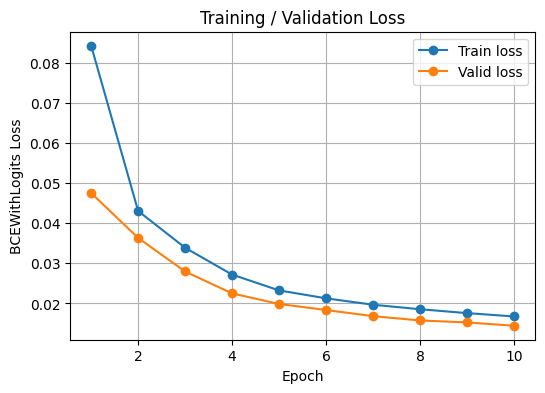

In [13]:
# ----- Loss plot -----
import matplotlib.pyplot as plt
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses_gat, marker="o", label="Train loss")
plt.plot(epochs, valid_losses_gat, marker="o", label="Valid loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogits Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# ================================================
# EMA utils (teacher parameters update)
# ================================================
import copy

def create_ema_model(model):
    ema_model = copy.deepcopy(model)
    for p in ema_model.parameters():
        p.requires_grad_(False)
    return ema_model

def update_ema_model(ema_model, model, alpha=0.99):
    """
    ema_model: teacher (no grad)
    model    : student (gradient update되는 모델)
    alpha    : EMA momentum (0.99 ~ 0.999 권장)
    """
    for p_te, p in zip(ema_model.parameters(), model.parameters()):
        p_te.data.mul_(alpha).add_(p.data, alpha=1.0 - alpha)

In [15]:
# ================================================
# Pseudo-label refinement with EMA teacher
# ================================================
def refine_labels_with_teacher(
    teacher_model,
    X_np: np.ndarray,
    Y_old: np.ndarray,
    t_pos: float = 0.9,
    t_neg: float = 0.1
):
    teacher_model.eval()
    X = torch.from_numpy(X_np).float().to(device)

    with torch.no_grad():
        logits = teacher_model(X)
        probs = torch.sigmoid(logits).cpu().numpy()   # (N, C)

    Y_new = Y_old.copy()

    # 확실한 positive
    pos_mask = probs >= t_pos
    Y_new[pos_mask] = 1.0

    # 확실한 negative (원래 1이던 것만 0으로)
    neg_mask = probs <= t_neg
    drop_mask = (Y_new == 1.0) & neg_mask
    Y_new[drop_mask] = 0.0

    print("Refinement summary:")
    print("  newly set to 1:", int(pos_mask.sum()))
    print("  dropped from 1:", int(drop_mask.sum()))

    return Y_new, probs

In [16]:
# ================================================
# 15. SELF-TRAINING: PSEUDO LABEL REFINEMENT
# ================================================
import numpy as np
import torch
import copy

def refine_labels_with_self_training(
    model,
    X_np: np.ndarray,
    Y_old: np.ndarray,
    t_pos: float = 0.9,
    t_neg: float = 0.1
):
    """
    model : 이미 학습된 teacher 모델 (예: model_gat)
    X_np  : train_doc_emb (N, dim)
    Y_old : 기존 silver label (N, C)
    t_pos : positive로 '확실히 추가'할 threshold
    t_neg : 기존 positive를 '확실히 제거'할 threshold

    return:
        Y_new : refined silver labels
        probs : 모델의 예측 확률 (N, C)
    """
    model.eval()
    X = torch.from_numpy(X_np).float().to(device)

    with torch.no_grad():
        logits = model(X)                        # (N, C)
        probs = torch.sigmoid(logits).cpu().numpy()

    Y_new = Y_old.copy()

    # 1) 확실한 positive: prob >= t_pos
    pos_mask = probs >= t_pos
    Y_new[pos_mask] = 1.0

    # 2) 확실한 negative: prob <= t_neg 이면서 원래 1이었던 것만 0으로
    neg_mask = probs <= t_neg
    drop_mask = (Y_new == 1.0) & neg_mask
    Y_new[drop_mask] = 0.0

    print("Refinement summary:")
    print("  newly set to 1:", int(pos_mask.sum()))
    print("  dropped from 1:", int(drop_mask.sum()))

    return Y_new, probs

In [17]:
# teacher 모델: GAT 버전이라고 가정
teacher_model = model_gat

Y_refined, train_probs = refine_labels_with_self_training(
    teacher_model,
    train_doc_emb,
    Y_silver,
    t_pos=0.9,
    t_neg=0.1
)

print("Y_silver sum:", Y_silver.sum())
print("Y_refined sum:", Y_refined.sum())

Refinement summary:
  newly set to 1: 31397
  dropped from 1: 22448
Y_silver sum: 139753.0
Y_refined sum: 117522.0


In [18]:
# ================================================
# 16. SELF-TRAINING: STUDENT 모델 재학습
# ================================================

# 1) refined 라벨로 새 dataset 구성
dataset_refined = EmbeddingDataset(train_doc_emb, Y_refined)

train_size = int(0.9 * len(dataset_refined))
valid_size = len(dataset_refined) - train_size
train_dataset_ref, valid_dataset_ref = random_split(dataset_refined, [train_size, valid_size])

BATCH_SIZE = 256
train_loader_ref = DataLoader(train_dataset_ref, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_ref = DataLoader(valid_dataset_ref, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# teacher 모델 copy → student
student_model = copy.deepcopy(teacher_model).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_student = torch.optim.Adam(student_model.parameters(), lr=1e-3)

EPOCHS_ST = 5  # self-training 단계는 짧게 fine-tune 느낌으로
train_losses_st = []
valid_losses_st = []

for epoch in range(1, EPOCHS_ST + 1):
    # ---- train ----
    student_model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader_ref:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_student.zero_grad()
        logits = student_model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer_student.step()

        total_loss += loss.item() * batch_x.size(0)

    avg_train = total_loss / len(train_loader_ref.dataset)
    train_losses_st.append(avg_train)

    # ---- valid ----
    student_model.eval()
    total_v = 0.0
    with torch.no_grad():
        for batch_x, batch_y in valid_loader_ref:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = student_model(batch_x)
            loss = criterion(logits, batch_y)
            total_v += loss.item() * batch_x.size(0)

    avg_valid = total_v / len(valid_loader_ref.dataset)
    valid_losses_st.append(avg_valid)

    print(f"[Self-Training Epoch {epoch:02d}] "
          f"train={avg_train:.4f} | valid={avg_valid:.4f}")

[Self-Training Epoch 01] train=0.0109 | valid=0.0083
[Self-Training Epoch 02] train=0.0100 | valid=0.0077
[Self-Training Epoch 03] train=0.0096 | valid=0.0081
[Self-Training Epoch 04] train=0.0093 | valid=0.0074
[Self-Training Epoch 05] train=0.0090 | valid=0.0071


In [20]:
# ================================================
# EMA-based Self-Training (Temporal Ensemble)
# ================================================
# 1) 초기 teacher = 학습 끝난 GAT 모델의 EMA copy
ema_model = create_ema_model(model_gat)
alpha_ema = 0.99            # 슬라이드의 α
t_pos = 0.9                 # high-confidence positive
t_neg = 0.1                 # high-confidence negative
ROUNDS = 2                  # self-training 라운드 수 (2~3 정도 추천)
EPOCHS_ST = 3               # 라운드마다 fine-tune epoch 수

Y_current = Y_silver.copy()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model_gat.parameters(), lr=1e-3)

lambda_hier = 0.1   # ← 계층 패널티 비율, 여기 한 줄 추가!

EPOCHS = 10
train_losses_gat = []
valid_losses_gat = []

for r in range(1, ROUNDS + 1):
    print(f"\n==== EMA Self-Training Round {r} ====")

    # 2) EMA teacher로 pseudo-label refinement
    Y_refined, train_probs = refine_labels_with_teacher(
        ema_model,
        train_doc_emb,
        Y_current,
        t_pos=t_pos,
        t_neg=t_neg,
    )

    # 3) refined label로 새 dataset/dataloader 구성
    dataset_refined = EmbeddingDataset(train_doc_emb, Y_refined)
    train_size = int(0.9 * len(dataset_refined))
    valid_size = len(dataset_refined) - train_size
    train_dataset_ref, valid_dataset_ref = random_split(dataset_refined, [train_size, valid_size])

    train_loader_ref = DataLoader(train_dataset_ref, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader_ref = DataLoader(valid_dataset_ref, batch_size=BATCH_SIZE, shuffle=False)

    # 4) student(GAT) 모델을 refined 라벨로 다시 학습
    criterion_st = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer_st = torch.optim.Adam(model_gat.parameters(), lr=1e-3)

    for epoch in range(1, EPOCHS_ST + 1):
        model_gat.train()
        total_loss = 0.0

        for batch_x, batch_y in train_loader_ref:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer_st.zero_grad()
            logits = model_gat(batch_x)
            probs  = torch.sigmoid(logits)

            bce_loss  = criterion_st(logits, batch_y)
            hier_loss = hierarchical_penalty(probs, edges_tensor)

            loss = bce_loss + lambda_hier * hier_loss
            loss.backward()
            optimizer_st.step()

            # ★ student 업데이트 후, EMA teacher도 함께 업데이트
            update_ema_model(ema_model, model_gat, alpha=alpha_ema)

            total_loss += loss.item() * batch_x.size(0)

        avg_train = total_loss / len(train_loader_ref.dataset)

        # 간단 valid loss
        model_gat.eval()
        total_v = 0.0
        with torch.no_grad():
            for batch_x, batch_y in valid_loader_ref:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                logits = model_gat(batch_x)
                probs  = torch.sigmoid(logits)

                bce_loss  = criterion_st(logits, batch_y)
                hier_loss = hierarchical_penalty(probs, edges_tensor)
                v_loss = bce_loss + lambda_hier * hier_loss

                total_v += v_loss.item() * batch_x.size(0)

        avg_valid = total_v / len(valid_loader_ref.dataset)
        print(f"[Round {r} / Epoch {epoch}] "
              f"train={avg_train:.4f} | valid={avg_valid:.4f}")

    # 5) 다음 라운드는 이번에 얻은 라벨을 기반으로
    Y_current = Y_refined


==== EMA Self-Training Round 1 ====
Refinement summary:
  newly set to 1: 31397
  dropped from 1: 22448
[Round 1 / Epoch 1] train=0.1122 | valid=0.0636
[Round 1 / Epoch 2] train=0.0824 | valid=0.0583
[Round 1 / Epoch 3] train=0.0774 | valid=0.0536

==== EMA Self-Training Round 2 ====
Refinement summary:
  newly set to 1: 155289
  dropped from 1: 180
[Round 2 / Epoch 1] train=556.9822 | valid=8.6622
[Round 2 / Epoch 2] train=0.7432 | valid=0.3649
[Round 2 / Epoch 3] train=0.3995 | valid=0.3993


In [21]:
# ================================================
# 17. TEST PREDICTION WITH SELF-TRAINED STUDENT
# ================================================
pid_list_test = np.load(EMB_MP_DIR / "pid_list_test.npy", allow_pickle=True)

student_model.eval()
with torch.no_grad():
    test_x = torch.from_numpy(test_doc_emb).float().to(device)
    test_logits = student_model(test_x)
    test_probs = torch.sigmoid(test_logits).cpu().numpy()

TOP_K = 3
topk_indices = np.argsort(-test_probs, axis=1)[:, :TOP_K]

labels_str_list = [
    ",".join(str(int(c)) for c in row)
    for row in topk_indices
]

import pandas as pd
SUB_ST_PATH = ROOT / "submissions" / "submission_selftrain_gat_top32.csv"
SUB_ST_PATH.parent.mkdir(exist_ok=True, parents=True)

submission_st = pd.DataFrame({
    "id": pid_list_test.astype(str),
    "labels": labels_str_list
})

submission_st.to_csv(SUB_ST_PATH, index=False, encoding="utf-8")
print("Saved self-training submission:", SUB_ST_PATH)
print(submission_st.head())

Saved self-training submission: Amazon_products/submissions/submission_selftrain_gat_top32.csv
  id     labels
0  0  10,64,473
1  1   168,3,17
2  2   3,40,169
3  3    0,208,8
4  4   10,54,11
